# Quelques fournitures pour le projet d'apprentissage semi-supervisé

## CIFAR-10

Il vous est demandé pour ce projet d'utiliser les données de la base de données CIFAR-10, que vous pouvez récupérer avec les quelques lignes ci-dessous. Cette base de données est constituée des 10 classes suivantes : 


A vous de partager cette base en données labellisées et non labellisées en fonction des expériences que vous mènerez !

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils import data

import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

In [2]:
# Set device
if float(torch.__version__.split(".")[1]) >= 13 and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
                                        
trainloader = data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
                                       
testloader = data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [01:03<00:00, 2687925.12it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
trainloader.__iter__().__next__()[0].shape

torch.Size([4, 3, 32, 32])

## RandAugment

Pour implémenter l'augmentation forte dans FixMatch, vous aurez besoin d'une politique d'augmentation de données apprise par renforcement. La méthode RandAugment a été implémentée dans la bibliothèque imgaug, voici comment l'utiliser

In [9]:
from torchvision.transforms import RandAugment

aug = RandAugment(num_ops= 2, magnitude=9)

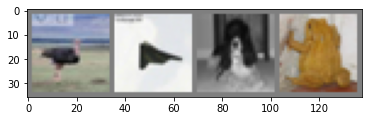

bird  plane dog   frog 


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [14]:
images[0].shape

torch.Size([3, 32, 32])

In [16]:
imshow(aug(images[0]))

TypeError: Threshold should be less than bound of img.

In [11]:
# show images
imshow(torchvision.utils.make_grid(aug(images)))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

TypeError: Only torch.uint8 image tensors are supported, but found torch.float32

In [ ]:
import matplotlib.pyplot as plt

# Application de RandAugment aux 4 premières images de la base d'entraînement
aug_img = aug(x_train[0:4])

# Affichage des images originales (ligne du haut) et augmentées (ligne du bas)
for i in range(4):
  plt.subplot(2,4,i+1)
  plt.imshow(x_train[i])

  plt.subplot(2,4, i+5)
  plt.imshow(aug_img[i])

## Réseau fourni

Afin d'obtenir des résultats comparables, tout le monde devra utiliser le même réseau, que voici :

In [4]:
# implementation in PyTorch of a simple CNN

class ConvNN(nn.Module):
    """
    Simple CNN for CIFAR10
    """
    
    def __init__(self):
        super().__init__()
        self.conv_32 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.conv_64 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv_96 = nn.Conv2d(64, 96, kernel_size=3, padding='same')
        self.conv_128 = nn.Conv2d(96, 128, kernel_size=3, padding='same')
        self.fc_512 = nn.Linear(128, 512)
        self.fc_10 = nn.Linear(512, 10)
        self.max_pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.soft_max = nn.Softmax(dim=1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv_32(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_64(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_96(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_128(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.flatten(x)
        x = self.fc_512(x)
        x = self.relu(x)
        x = self.fc_10(x)
        x = self.soft_max(x)
        
        return x